# Analysis of Singapore's Bus Data
## Hands-on attempt at understanding the datasets and doing some data visualisations.

In [1]:
import pandas as pd 

# To sort the obtained data set: 
First, import the origin destination trip records using pandas' `read_csv` which reads a csv file. 
<br> The `usecols` argument allows you to select the columns required for your dataframe.

In [2]:
od_three_months = pd.read_csv('Data/od_three_months.csv',\
                usecols=['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE', 'TOTAL_TRIPS'])

od_three_months['ORIGIN_PT_CODE'] = od_three_months['ORIGIN_PT_CODE'].astype("str").str.zfill(5)
od_three_months['DESTINATION_PT_CODE'] = od_three_months['DESTINATION_PT_CODE'].astype("str").str.zfill(5)

Since we have three months worth of data, it is easier to analyse it when the data is combined as a whole. 
The `.groupby` method takes in an attribute, and groups the data according to the categories, then applies a function to the category. 

In [3]:
od_modified = od_three_months.groupby(['ORIGIN_PT_CODE', 'DESTINATION_PT_CODE'])['TOTAL_TRIPS'].sum()
od_stops = od_modified.reset_index()

In [4]:
od_stops.head()

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS
0          01012               01112         4821
1          01012               01113         3660
2          01012               01121         2306
3          01012               01211         3432
4          01012               01311         5780

Next, import the bus stop data. 

In [5]:
bus_stops = pd.read_csv('Data/bus_stops.csv')
bus_stops["BusStopCode"] = bus_stops["BusStopCode"].astype("str").str.zfill(5)
bus_stops.head(5)

BusStopCode       RoadName          Description  Latitude   Longitude
0       01012    Victoria St  Hotel Grand Pacific  1.296848  103.852536
1       01013    Victoria St      St. Joseph's Ch  1.297710  103.853225
2       01019    Victoria St      Bras Basah Cplx  1.296990  103.853022
3       01029  Nth Bridge Rd         Opp Natl Lib  1.296673  103.854414
4       01039  Nth Bridge Rd           Bugis Cube  1.298208  103.855491

For a more comprehensive overview of where the bus stops are located, we will require the **subzone** name and **region** of each bus stop. As we will deal with geospatial data, we require the following packages: `geopandas`, `numpy`, and `matplotlib.pyplot`. 

Import the geospatial data, using geoppanda's `read_file` function, which reflects the division of land in Singapore based on URA's Master Plan 2019. 

In [6]:
import geopandas as gpd
import numpy as np 
import matplotlib.pyplot as plt

In [7]:
geo_df = gpd.read_file('Data/MP19_SZ_No_Sea/URA_MP19_SUBZONE_NO_SEA_PL.shp')

To ensure that we are evaluating the geodataframe with the correct Coordinate Reference System (CRS), we use `.to_crs(epsg value)` with the correct epsg value.

In [8]:
geo_df_reproj = geo_df.to_crs(3857)

To view the columns in the imported geodataframe, use `.columns`.

In [9]:
geo_df_reproj.columns

Index(['SUBZONE_NO', 'SUBZONE_N', 'SUBZONE_C', 'CA_IND', 'PLN_AREA_N',
       'PLN_AREA_C', 'REGION_N', 'REGION_C', 'INC_CRC', 'FMEL_UPD_D',
       'geometry'],
      dtype='object')

To merge the geodataframe with the bus stop dataset, we need to first convert the bus stop dataframe into a geodataframe.
<br> We do so by creating a representation of the geometry. We initialise a `geometry` column in the bus stop dataframe with the `Point` constructor function from the geometry module of the shapely package, `shapely.geometry`. Then, we ensure that the CRS of the bus stop geodataframe matches that of URA's Master Plan.

In [10]:
from shapely.geometry import Point
# Creating a point geometry column
bus_stops['geometry'] = bus_stops.apply(lambda x: Point((x.Longitude, x.Latitude)),
                                       axis = 1)

In [11]:
# Create a GeoDataFrame from the original bus_stops DataFrame
bus_stops_geo = gpd.GeoDataFrame(bus_stops, 
                                 crs = "epsg:4326",
                                 geometry = bus_stops.geometry)
bus_stops_geo_reproj = bus_stops_geo.to_crs(3857)

The two geodataframes can then be merged with `.sjoin`, a function of geopandas that allows us to combine the two layers we have - the bus stops across Singapore (which are points) and the geodataframe encoding the division of Singapore's land. It is important to specify the `how` argument of `.sjoin` to ensure that data is not lost. 
<br> The below `.sjoin` call results in the merger of the two files, with `bus_stops_geo_reproj` as the base file. The `geometry` column of `geo_df_reproj` is thus lost.

In [12]:
joined_gdf = gpd.sjoin(bus_stops_geo_reproj, 
                       geo_df_reproj, 
                       how = 'left')

As I will only require the BusStopCode, Subzone Name and Region Name, the geodataframe obtained, `joined_gdf`, needs to be subset by columns. 
I will also need to convert the subsequent GeoDataFrame into a DataFrame for further analysis. 

In [13]:
joined_gdf.columns

Index(['BusStopCode', 'RoadName', 'Description', 'Latitude', 'Longitude',
       'geometry', 'index_right', 'SUBZONE_NO', 'SUBZONE_N', 'SUBZONE_C',
       'CA_IND', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N', 'REGION_C', 'INC_CRC',
       'FMEL_UPD_D'],
      dtype='object')

In [14]:
# Subset the current joined geo_df to get the columns I need.
required_bus_stops = joined_gdf[['BusStopCode', 'SUBZONE_N', 'PLN_AREA_N', 'REGION_N']]
required_bus_stops.head()
bus_stops_df = pd.DataFrame(required_bus_stops)

The purpose of merging the origin-destination trip records and the bus stop data (where the subzone, planning area, and region of each bus stop has been identified) is to allow us to better identify where the start and stop bus stops are situated at. <br> Here, we use the `.merge` function from the `pandas` package. `.merge` takes in two dataframes, and the `how` argument allows us to specify how we want to join the data. <br> The `on` argument specifies the column or index level names to join on. Specifically, `left_on` specifies the column levels from the left dataframe to use as keys. Likewise, `right_on` specifies the same information from the right dataframe to use as keys. The datasets are merged _twice_ so that we get information on both origin and destination bus stops. 

In [15]:
# To join the 2 datasets we have obtained:
od_stops = pd.merge(od_stops, bus_stops_df,\
                    how = 'left', left_on ='ORIGIN_PT_CODE', right_on = 'BusStopCode')
od_stops = pd.merge(od_stops, bus_stops_df,\
             how = 'left', left_on = 'DESTINATION_PT_CODE', right_on = 'BusStopCode')
od_stops.head(10)

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS BusStopCode_x SUBZONE_N_x  \
0          01012               01112         4821         01012    VICTORIA   
1          01012               01113         3660         01012    VICTORIA   
2          01012               01121         2306         01012    VICTORIA   
3          01012               01211         3432         01012    VICTORIA   
4          01012               01311         5780         01012    VICTORIA   
5          01012               01549           22         01012    VICTORIA   
6          01012               01559           78         01012    VICTORIA   
7          01012               07371          227         01012    VICTORIA   
8          01012               60011          321         01012    VICTORIA   
9          01012               60021          343         01012    VICTORIA   

  PLN_AREA_N_x      REGION_N_x BusStopCode_y    SUBZONE_N_y   PLN_AREA_N_y  \
0       ROCHOR  CENTRAL REGION         01112       VICTORIA         ROCHOR   
1       ROCHOR  CENTRAL REGION         01113          BUGIS  DOWNTOWN CORE   
2       ROCHOR  CENTRAL REGION         01121   ROCHOR CANAL         ROCHOR   
3       ROCHOR  CENTRAL REGION         01211       CRAWFORD        KALLANG   
4       ROCHOR  CENTRAL REGION         01311       LAVENDER        KALLANG   
5       ROCHOR  CENTRAL REGION         01549   KAMPONG GLAM         ROCHOR   
6       ROCHOR  CENTRAL REGION         01559   KAMPONG GLAM         ROCHOR   
7       ROCHOR  CENTRAL REGION         07371       LAVENDER        KALLANG   
8       ROCHOR  CENTRAL REGION         60011  KALLANG BAHRU        KALLANG   
9       ROCHOR  CENTRAL REGION         60021  KALLANG BAHRU        KALLANG   

       REGION_N_y  
0  CENTRAL REGION  
1  CENTRAL REGION  
2  CENTRAL REGION  
3  CENTRAL REGION  
4  CENTRAL REGION  
5  CENTRAL REGION  
6  CENTRAL REGION  
7  CENTRAL REGION  
8  CENTRAL REGION  
9  CENTRAL REGION

In [16]:
# rename the df for easier use
final_df = od_stops
final_df.shape

(372020, 11)

## Filtering the dataframe
The function `filter_trips()` below allows us to easily filter the data frame we are working on, to obtain a subset of the data set.  

In [17]:
def filter_trips(od_stops,
                 level, # 'SUBZONE', 'PLN_AREA', 'REGION'
                 selected_origin, # ['VICTORIA']
                 selected_dest, # 'all' OR ['CHONG BOON', 'CHONG PANG']
                 min_trips): # 5000
    '''
    Filters the origin-destination dataframe for selected origin-destination pairs
    and for a minimum number of trips.

    Args:
        od_stops: Pandas dataframe of all origin-destination bus stops and trip numbers
        level: Which geospatial level to filter at (subzone, planning area, or region)
        selected_origin: The origin area(s) in the level selected 
        selected_dest: The destination area(s) in the level selected
        min_trips: integer value of the minimum number of trips to be filtered
    Returns:
        What do you return? Pandas dataframe which is filtered
    Raises:
        AssertionError: For incorrect inputs
    '''

    # Check that the level that was passed in is correct
    if level not in ['SUBZONE', 'PLN_AREA', 'REGION']:
        raise AssertionError("Error! Please key in a correct level.")

    # Check that there is some selection
    if len(selected_origin) == 0:
        raise AssertionError("Error! Please select at least one origin.")
    if len(selected_dest) == 0:
        raise AssertionError("Error! Please select at least one destination.")

    # Check that min_trips is at least 1
    if min_trips < 0:
        raise AssertionError("Error! Please key in a positive integer value \
                                to be the minimum number of trips.")
        
    def generate_boolean_mask(df, level, origin_dest, selected):
        if selected == 'all':
            boolean_mask = ~df[f'{level}_N_{origin_dest}'].isin([])
        else:
            boolean_mask = df[f'{level}_N_{origin_dest}'].isin(selected)
        return boolean_mask

    boolean_mask_origin = generate_boolean_mask(od_stops,
                                           level,
                                           "x",
                                           selected_origin)

    boolean_mask_dest = generate_boolean_mask(od_stops,
                                           level,
                                           "y",
                                           selected_dest)

    boolean_mask_mintrips = od_stops['TOTAL_TRIPS'] >= min_trips

    output = od_stops[boolean_mask_origin & boolean_mask_dest & boolean_mask_mintrips].reset_index(drop = True)

    return output

In [18]:
# To test written code:
filter_trips(final_df, 'SUBZONE', ['VICTORIA'], ['BUGIS'], 5)

ORIGIN_PT_CODE DESTINATION_PT_CODE  TOTAL_TRIPS BusStopCode_x SUBZONE_N_x  \
0          01012               01113         3660         01012    VICTORIA   
1          01013               01113          617         01013    VICTORIA   
2          07518               01511          440         07518    VICTORIA   
3          07518               01621          411         07518    VICTORIA   
4          07518               01639         1699         07518    VICTORIA   
5          07569               01511          227         07569    VICTORIA   
6          07569               01621          130         07569    VICTORIA   
7          07569               01639          415         07569    VICTORIA   

  PLN_AREA_N_x      REGION_N_x BusStopCode_y SUBZONE_N_y   PLN_AREA_N_y  \
0       ROCHOR  CENTRAL REGION         01113       BUGIS  DOWNTOWN CORE   
1       ROCHOR  CENTRAL REGION         01113       BUGIS  DOWNTOWN CORE   
2       ROCHOR  CENTRAL REGION         01511       BUGIS  DOWNTOWN CORE   
3       ROCHOR  CENTRAL REGION         01621       BUGIS  DOWNTOWN CORE   
4       ROCHOR  CENTRAL REGION         01639       BUGIS  DOWNTOWN CORE   
5       ROCHOR  CENTRAL REGION         01511       BUGIS  DOWNTOWN CORE   
6       ROCHOR  CENTRAL REGION         01621       BUGIS  DOWNTOWN CORE   
7       ROCHOR  CENTRAL REGION         01639       BUGIS  DOWNTOWN CORE   

       REGION_N_y  
0  CENTRAL REGION  
1  CENTRAL REGION  
2  CENTRAL REGION  
3  CENTRAL REGION  
4  CENTRAL REGION  
5  CENTRAL REGION  
6  CENTRAL REGION  
7  CENTRAL REGION

# Generating the chord diagram

In [40]:
# Shaun's function for generating the chord diagram data

pd.options.mode.chained_assignment = None

def generate_chord_diagram(final_df, level, areas):
    
    '''
    Generates the dataset that has all information required in the appropriate structure to build a chord diagram.

    Args:
        final_df: The dataframe to be filtered
        level: Which geospatial level to filter at (subzone, planning area, or region)
        areas: A list of area(s) in the level selected

    Returns:
        What do you return? Pandas dataset which has the required structure for a chord diagram visualisation.

    Raises:
        AssertionError: For incorrect inputs
    '''
    
     # Check that the level that was passed in is correct
    if level not in ['SUBZONE', 'PLN_AREA', 'REGION']:
        raise AssertionError("Error! Please key in a correct level.")

    # Check that there is some selection
    if len(areas) == 0:
        raise AssertionError("Error! Please select at least one area.")
    if len(areas) > 3:
        raise AssertionError("Error! Please select at most three areas.")
    
    
    # Filter the data for only the areas we have selected
    selected_areas_df = final_df[final_df[f'{level}_N_x'].isin(areas) & final_df[f'{level}_N_y'].isin(areas)]
    
    # Filter the data for the rest of the trips
    other_areas_df = final_df[(final_df[f'{level}_N_x'].isin(areas) & ~final_df[f'{level}_N_y'].isin(areas)) | (~final_df[f'{level}_N_x'].isin(areas) & final_df[f'{level}_N_y'].isin(areas))]
    
    # Convert the other non-selected towns into "OTHERS"
    other_areas_df[f'{level}_N_x'] = [pln_area if pln_area in areas else 'ZZOTHERS' for pln_area in other_areas_df[f'{level}_N_x']]
    other_areas_df[f'{level}_N_y'] = [pln_area if pln_area in areas else 'ZZOTHERS' for pln_area in other_areas_df[f'{level}_N_y']]
    
    # Add them all back together
    limited_areas_df = pd.concat([selected_areas_df, other_areas_df], ignore_index = True)
    
    # Group by the planning area and sum the total trips
    trips2 = limited_areas_df.groupby([f'{level}_N_x', f'{level}_N_y'])['TOTAL_TRIPS'].sum()
    links2 = pd.DataFrame.from_records(list(trips2.index), columns = ['start', 'end'])
    links2['trips'] = trips2.values
    
    links2['set'] = ''
    for i in range(len(links2)):
        links2['set'][i] = ','.join(sorted([links2['start'][i], links2['end'][i]]))
    chord_df = links2.groupby('set')['trips'].sum().reset_index()
    chord_final = pd.concat([chord_df, chord_df['set'].str.split(',', expand = True)], axis = 1)
    chord_final.drop('set', inplace = True, axis = 1)
    chord_final.columns = ['value', 'source', 'target']
    chord_final['source'] = chord_final['source'].replace({k:str(i) for i,k in enumerate(selected_towns)}).replace({'ZZOTHERS': len(selected_towns)}).astype('int32')
    chord_final['target'] = chord_final['target'].replace({k:str(i) for i,k in enumerate(selected_towns)}).replace({'ZZOTHERS': len(selected_towns)}).astype('int32')
    
    nodes = hv.Dataset(pd.DataFrame(selected_towns + ['OTHERS'], columns = ['name']), 'index')
    
    return nodes, chord_final.loc[:,['source', 'target', 'value']]

Note that this function ensures that:
* Trips are summed bidirectionally (ie it doesn't matter if it's A -> B or B -> A, we sum the traffic both ways.
* `OTHERS` will always be the last category, regardless of how many towns you pass in. The links will also never be coloured with the `OTHERS` colour.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
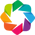

In [20]:
from holoviews import opts, dim
import holoviews as hv

hv.extension('bokeh')
hv.output(size=200)

## Generating a chord diagram with holoviews
Feel free to change the `generate_chord_diagram` function call below.
<br> Identify which level you wish to see the visualisation at - change the `levels` argument to either `'REGION'`, `'PLN_AREA'`, or `'SUBZONE'`.
<br> Input a maximum of three selected towns at the level you desire through changing the items in the list. An example is shown below. 
Run the code. 

In [44]:
selected_towns = ['BUKIT BATOK', 'CLEMENTI', 'JURONG EAST']
nodes, links = generate_chord_diagram(final_df, 'PLN_AREA', selected_towns)
chord = hv.Chord((links, nodes))
chord.opts(node_color=dim('index').str(),
           edge_color=dim('source').str(),
           labels='name', 
           cmap='Category10',
           edge_cmap='Category10')

:Chord   [source,target]   (value)

To get a better understanding of the chart, run `print(links)` below to view the **total number of trips** from one area to another. 

The `value` column represents the total trips, while the source and index values show the direction of passenger flow from area to area. 

In the example shown here, with `selected_towns = ['BUKIT BATOK', 'CLEMENTI', 'JURONG EAST']` at the `PLN_AREA` level, index 0 refers to the **Bukit Batok planning area**, 1 refers to the **Clementi Planning Area**, 2 refers to the **Jurong East planning area**, and 3 refers to other subzones.

To guide you in understanding the chord diagram:
<br> The flow of passengers between the three planning areas is clearly dermacated by the _colour_ of the link from one planning area to another. All blue links belong to Bukit Batok, i.e. passengers are coming from `Bukit Batok` to either `Bukit Batok`, `Clementi`, `Jurong East`, or `Others`. Similarly, this logic can be applied to the other mentioned planning areas - orange belongs to `Clementi` and green belongs to `Jurong East`. 
<br> As observed in the chord diagram, there is **significantly less** movement between the selected subzones. It is visually obvious that there is more intra-planning area movement than inter-planning area movement here. 
<br> For example, from the numbers shown when `print(links)` is run, it is evident that there is significantly fewer trip records from `Bukit Batok` to `Clementi` <mark>(680149 trips)</mark> or from `Bukit Batok` to `Jurong East` <mark>(1259934 trips)</mark> than **within** `Bukit Batok` itself <mark> (5133020 trips) </mark>.
<br> A possible explanation for this result is that it might be _more convenient_ to travel between these planning areas by the Mass Rapid Transit (MRT) instead due to the interconnected nature of the MRT stations. 

<!-- ![Image of MRT Line - Bukit Batok, Clementi and Jurong East are at the first intersection between the Green Line and the Red Line (image credits: Google)](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.straitstimes.com%2Fsingapore%2Ftransport%2Fnew-mrt-map-online-reactions-mostly-positive-but-some-prefer-the-old-map&psig=AOvVaw0rURRBVUDRcNjQzAle5j6q&ust=1631169891948000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCJjkvMLj7vICFQAAAAAdAAAAABAJ) -->

In [134]:
print(links)

   source  target    value
0       0       0  5133020
1       0       1   680149
2       0       2  1259934
3       0       3  4379888
4       1       1  3790163
5       1       2  1789182
6       1       3  4513125
7       2       2  3509990
8       2       3  4416456


# Analysing the data
## Evaluation Points
With the data we've obtained and processed above, we need to make sense of the data by analysing it (on top of visualising it).
<br> First, we can view the area with the greatest volume of passenger flow. 
<!-- 1) Area with the greatest volume of passenger flow  -- assumed to be the town area/jurong industrial area
2) Bus stop density (within subzones)
3) When viewing the data, we should consider the relationship of the ridership and number of bus stops in the area, alongside : 
        a. population density 
        b. the type of residence in the planning area 
        c. land size 
        d. number of bus stops per km^2 
4) Relationship between the ridership and bus stop density/number of bus stops per km^2/population density/planning area level/subzone level. (Plot as points, then draw a best fit line).  -->


In [137]:
#1 Area with the greatest volume of passenger flow OUT (passengers BOARDING at this bus stop)
# Assessed by total trips TO destination bus stop, using final_df
greatest_trips_out_of_area = final_df.groupby('ORIGIN_PT_CODE')['TOTAL_TRIPS'].sum()
greatest_trips_out_of_area.sort_values(ascending=False).reset_index()

ORIGIN_PT_CODE  TOTAL_TRIPS
0             22009      4378682
1             46009      3412648
2             75009      2993823
3             52009      2265524
4             59009      2264948
...             ...          ...
5008          32061            5
5009          32071            4
5010          46239            3
5011          59599            1
5012          22579            1

[5013 rows x 2 columns]

As my dataframes containing the total trip records and bus stop details are separate, I will query for the top 5 bus stop codes in the `bus_stops` dataframe.  

In [33]:
bus_stop_codes = ['22009', '46009', '75009', '52009', '59009']
condition = bus_stops['BusStopCode'].isin(bus_stop_codes)
bus_stops[condition]

BusStopCode            RoadName    Description  Latitude   Longitude  \
977        22009  Jurong West Ctrl 3   Boon Lay Int  1.339323  103.705457   
2268       46009        Woodlands Sq  Woodlands Int  1.436874  103.786162   
2655       52009     Lor 6 Toa Payoh  Toa Payoh Int  1.332021  103.846928   
3157       59009        Yishun Ave 2     Yishun Int  1.428400  103.836097   
4104       75009     Tampines Ctrl 1   Tampines Int  1.354076  103.943391   

                       geometry  
977   POINT (103.70546 1.33932)  
2268  POINT (103.78616 1.43687)  
2655  POINT (103.84693 1.33202)  
3157  POINT (103.83610 1.42840)  
4104  POINT (103.94339 1.35408)

We are also able to view the area with the greatest volume of passenger flow INTO the area.

In [136]:
#1b Area with the greatest volume of passenger flow IN (passengers ALIGHTING at this bus stop)
# Assessed by total trips TO destination bus stop, using final_df
greatest_trips_into_area = final_df.groupby('DESTINATION_PT_CODE')['TOTAL_TRIPS'].sum()
greatest_trips_into_area.sort_values(ascending=False).reset_index()

DESTINATION_PT_CODE  TOTAL_TRIPS
0                  22009      3781990
1                  75009      2982705
2                  46009      2607965
3                  84009      2220621
4                  52009      2099131
...                  ...          ...
5012               46219            5
5013               47711            4
5014               46109            4
5015               32059            4
5016               22571            4

[5017 rows x 2 columns]

In [35]:
bus_stop_codes = ['22009', '75009', '46009', '84009', '52009']
condition = bus_stops['BusStopCode'].isin(bus_stop_codes)
bus_stops[condition]

BusStopCode            RoadName    Description  Latitude   Longitude  \
977        22009  Jurong West Ctrl 3   Boon Lay Int  1.339323  103.705457   
2268       46009        Woodlands Sq  Woodlands Int  1.436874  103.786162   
2655       52009     Lor 6 Toa Payoh  Toa Payoh Int  1.332021  103.846928   
4104       75009     Tampines Ctrl 1   Tampines Int  1.354076  103.943391   
4558       84009        Bedok Nth Dr      Bedok Int  1.324539  103.929038   

                       geometry  
977   POINT (103.70546 1.33932)  
2268  POINT (103.78616 1.43687)  
2655  POINT (103.84693 1.33202)  
4104  POINT (103.94339 1.35408)  
4558  POINT (103.92904 1.32454)

## Bus Stop Densities by Subzones
#1 Counting the number of bus stops per subzone with the `.groupby()` and `.count()` functions.

In [109]:
req_cols = ['BusStopCode', 'SUBZONE_N']
bs_sz = bus_stops_df[req_cols].groupby('SUBZONE_N').count()
bs_sz_count = bs_sz.rename(columns = {"BusStopCode" : "count"})

### Trivia
#1a. Subzone with the greatest number of bus stops.

In [110]:
bs_sz_sorted = bs_sz_count.sort_values(by='count', ascending=False)
## Subzone MURAI has the most number of bus stops within itself -- 87. 
print(bs_sz_sorted.head(5))

               count
SUBZONE_N           
MURAI             87
TAMPINES EAST     83
FRANKEL           80
TUAS NORTH        57
TAMPINES WEST     55


#1b. Subzones with the least number of bus stops

In [111]:
sz_1_bus_stop = bs_sz_count[bs_sz_count["count"] == 1]
print(sz_1_bus_stop.index)

Index(['BAHAR', 'FOREST HILL', 'ISTANA NEGARA', 'LITTLE INDIA', 'MACKENZIE',
       'MAXWELL', 'MONK'S HILL', 'ORANGE GROVE', 'OXLEY', 'PHILLIP'],
      dtype='object', name='SUBZONE_N')


In [112]:
bs_sz_count.reset_index()

SUBZONE_N  count
0          ADMIRALTY     21
1       AIRPORT ROAD      3
2     ALEXANDRA HILL     24
3    ALEXANDRA NORTH      4
4           ALJUNIED     45
..               ...    ...
307     YISHUN SOUTH     26
308      YISHUN WEST     34
309       YUHUA EAST     17
310       YUHUA WEST     12
311           YUNNAN     51

[312 rows x 2 columns]

#2 To obtain the land areas per planning area/subzone, we need to do some data manipulation with `geopandas`.

In [113]:
geo_df_copy = geo_df.copy()
geo_df_copy['area'] = geo_df_copy['geometry'].area / 10**6
geo_df_copy.head(2)

SUBZONE_NO         SUBZONE_N SUBZONE_C CA_IND    PLN_AREA_N PLN_AREA_C  \
0           1       MARINA EAST    MESZ01      Y   MARINA EAST         ME   
1           5  INSTITUTION HILL    RVSZ05      Y  RIVER VALLEY         RV   

         REGION_N REGION_C           INC_CRC  FMEL_UPD_D  \
0  CENTRAL REGION       CR  4FB7E5B1B9455DE0  2019-12-23   
1  CENTRAL REGION       CR  C3C22D1EE31757BD  2019-12-23   

                                            geometry      area  
0  POLYGON ((33222.981 29588.127, 33222.515 29587...  1.844042  
1  POLYGON ((28481.446 30886.220, 28483.405 30886...  0.392563

In [114]:
pln_area_land = geo_df_copy.groupby(['PLN_AREA_N', 'PLN_AREA_C'])['area'].sum().reset_index()
pln_area_land

PLN_AREA_N PLN_AREA_C       area
0                ANG MO KIO         AM  13.942584
1                     BEDOK         BD  21.733967
2                    BISHAN         BS   7.608113
3                  BOON LAY         BL   8.282808
4               BUKIT BATOK         BK  11.140156
5               BUKIT MERAH         BM  14.461195
6             BUKIT PANJANG         BP   9.019940
7               BUKIT TIMAH         BT  17.514946
8   CENTRAL WATER CATCHMENT         CC  37.158689
9                    CHANGI         CH  41.471100
10               CHANGI BAY         CB   1.972608
11            CHOA CHU KANG         CK   6.117294
12                 CLEMENTI         CL   9.521318
13            DOWNTOWN CORE         DT   5.083637
14                  GEYLANG         GL   9.644797
15                  HOUGANG         HG  13.933043
16              JURONG EAST         JE  17.859886
17              JURONG WEST         JW  14.680540
18                  KALLANG         KL   8.584703
19             LIM CHU KANG         LK  17.495367
20                   MANDAI         MD  11.767308
21              MARINA EAST         ME   1.844042
22             MARINA SOUTH         MS   1.630380
23            MARINE PARADE         MP   6.133074
24                   MUSEUM         MU   0.829539
25                   NEWTON         NT   2.068722
26    NORTH-EASTERN ISLANDS         NE  67.250524
27                   NOVENA         NV   8.968012
28                  ORCHARD         OR   0.957525
29                   OUTRAM         OT   1.373191
30                PASIR RIS         PR  15.803181
31               PAYA LEBAR         PL  11.685293
32                  PIONEER         PN  12.219805
33                  PUNGGOL         PG   9.374278
34               QUEENSTOWN         QT  21.683970
35             RIVER VALLEY         RV   1.475698
36                   ROCHOR         RC   1.588461
37                  SELETAR         SL  10.848874
38                SEMBAWANG         SB  12.636194
39                 SENGKANG         SE  10.603044
40                SERANGOON         SG  10.100538
41                  SIMPANG         SM   8.283191
42          SINGAPORE RIVER         SR   0.957581
43         SOUTHERN ISLANDS         SI   7.126186
44             STRAITS VIEW         SV   1.127297
45             SUNGEI KADUT         SK  17.589075
46                 TAMPINES         TM  20.795428
47                  TANGLIN         TN   7.552300
48                   TENGAH         TH   7.363486
49                TOA PAYOH         TP   8.180213
50                     TUAS         TS  47.695035
51          WESTERN ISLANDS         WI  45.810445
52  WESTERN WATER CATCHMENT         WC  69.748336
53                WOODLANDS         WD  13.612515
54                   YISHUN         YS  20.874582

In [115]:
region_area_land = geo_df_copy.groupby('REGION_N')['area'].sum().reset_index()

REGION_N        area
0     CENTRAL REGION  136.393582
1        EAST REGION  113.461576
2       NORTH REGION  139.416922
3  NORTH-EAST REGION  136.052884
4        WEST REGION  259.459050

In [116]:
sz_land = geo_df_copy[['SUBZONE_N', 'area', 'geometry']]

SUBZONE_N       area  \
0                MARINA EAST   1.844042   
1           INSTITUTION HILL   0.392563   
2             ROBERTSON QUAY   0.506589   
3    JURONG ISLAND AND BUKOM  36.639387   
4               FORT CANNING   0.388733   
..                       ...        ...   
327            UPPER THOMSON   3.849507   
328               SHANGRI-LA   0.687914   
329               TOWNSVILLE   0.546394   
330                MARYMOUNT   1.964145   
331      TUAS VIEW EXTENSION  27.710219   

                                              geometry  
0    POLYGON ((33222.981 29588.127, 33222.515 29587...  
1    POLYGON ((28481.446 30886.220, 28483.405 30886...  
2    POLYGON ((28087.344 30540.999, 28087.540 30540...  
3    MULTIPOLYGON (((14557.697 30447.212, 14562.889...  
4    POLYGON ((29542.526 31041.199, 29553.718 31034...  
..                                                 ...  
327  POLYGON ((29036.498 38365.086, 29015.440 38293...  
328  POLYGON ((28228.195 39216.137, 28271.551 39216...  
329  POLYGON ((29649.875 38978.996, 29671.324 38978...  
330  POLYGON ((29469.703 36372.102, 29466.131 36348...  
331  MULTIPOLYGON (((4929.537 32139.355, 4502.137 3...  

[332 rows x 3 columns]

In [117]:
sz_land_df = pd.DataFrame(sz_land)

# Checking for missing values
sz_land_df.isna().any()

In [118]:
bus_density_sz1 = sz_land_df.merge(bs_sz_count, how = 'left', on = 'SUBZONE_N')

bd_sz1 = bus_density_sz1.fillna(value=0)

# To view the data I currently am showing in the dataframe. 
bd_sz1.head()

SUBZONE_N    False
area         False
geometry     False
dtype: bool

In [119]:
# Calculate the bus stop density by dividing the bus stop count by the area of the subzones.
bd_sz1['bus_stop_density'] = bd_sz1['count'] / bd_sz1['area']

In [120]:
# In order to visualise the data, we need to turn it into a GeoDataFrame.
bd_sz_gdf = gpd.GeoDataFrame(bd_sz1, geometry = bd_sz1['geometry'])
bd_sz_gdf

In [124]:
bd_sz_gdf.crs = 'EPSG:3414'

## Plotting the bus stop densities per subzones as a choropleth chart
Use of `folium` package.

In [125]:
import folium

In [127]:
# Need to reproject it back to EPSG 3857 first
bd_sz_gdf_reproj = bd_sz_gdf.to_crs(3857)

# Picking an appropriate centre point for Singapore
center_point = bd_sz_gdf_reproj[bd_sz_gdf_reproj['SUBZONE_N'].str.contains('UPPER THOMSON')]['geometry'].centroid

# Setting it back to the EPSG 4326 which is the default for Folium
center_point_mercator = center_point.to_crs(4326)

# Extracting the latitude and longitude
sg_center = [center_point_mercator.y.values[0], center_point_mercator.x.values[0]]

In [128]:
bd_sz_gdf_reproj['Subzone'] = bd_sz_gdf_reproj['SUBZONE_N']
bd_sz_gdf_reproj['Subzone Area'] = round(bd_sz_gdf_reproj['area'], 2).astype('str') + " km sq"
bd_sz_gdf_reproj['No. of Bus Stops'] = bd_sz_gdf_reproj['count'].astype('int').astype('str') + " bus stops"
bd_sz_gdf_reproj['Bus Stop Density'] = round(bd_sz_gdf_reproj['bus_stop_density'], 2).astype('str')

In [129]:
m = folium.Map(location = sg_center, 
               # tiles = "cartodb dark_matter", # for a dark map
               zoom_start = 12)
choropleth = folium.Choropleth(geo_data = bd_sz_gdf_reproj,
                               data = bd_sz_gdf_reproj, 
                               columns = ('SUBZONE_N', 'bus_stop_density'),
                               key_on = 'feature.properties.SUBZONE_N',
                               fill_color = 'OrRd',
                               fill_opacity = 0.5,
                               line_color = 'black', 
                               line_opacity = 1,
                               legend_name = 'Bus Stop Densities across Subzones in Singapore'
                               ).add_to(m)

choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['Subzone', 'Subzone Area', 'No. of Bus Stops', 'Bus Stop Density']))

In [ ]:
## Choropleth Chart showing the bus stop density across the various subzones in Singapore. 

In [132]:
display(m)

## Do it yourself! Fun fact function
Select an area to compute the number of bus stops within that area selected.

In [141]:
def bus_stops_within_area(level, area):
    
    '''
    Returns the number of bus stops in a particular area at the selected level.

    Args:
        level: Which geospatial level to filter at (subzone, planning area, or region)
        area: a list containing the area in the level selected

    Returns:
        An integer which is the number of bus stops in the area.
    Raises:
        AssertionError: For incorrect inputs
    '''

    # Check that the level that was passed in is correct
    if level not in ['SUBZONE', 'PLN_AREA', 'REGION']:
        raise AssertionError("Error! Please key in a correct level.")
        
    if len(area) != 1:
        raise AssertionError("Error! Please key in ONLY one area.")
        
    updated_df = bus_stops_df[[f'{level}_N', 'BusStopCode']]
    product = updated_df[updated_df[f'{level}_N'] == area[0]]
    
    # print(product)
    return len(product.index)

Feel free to change the arguments in the `bus_stops_within_area` function call below. 
<br> Choose from the following `level`s: `'REGION'`, `'PLN_AREA'`, and `'SUBZONE'`.
Make sure to insert a list (represented with `[]`) containing the area to be investigated.

In [142]:
bus_stops_within_area('PLN_AREA', ['ROCHOR'])

30

## Concluding Thoughts
There is definitely much more to explore in this dataset - such as observing the relationship between the actual ridership and the number of bus stops/buses that serve the areas, exploring overlapping bus routes to see if the passenger volume is equally distributed over the routes, etc... 
This has definitely piqued my interest in the datasets revolving around the public bus transportation system, and I'll continue to work on this project when I have the time to do so. 